In [239]:
import os

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms.functional as F
from scipy.optimize import linear_sum_assignment
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.ops import generalized_box_iou
from tqdm import tqdm



DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
QUERIES = 32
BATCH_SIZE = 16

In [227]:
class InBreastDataset(Dataset):
    def __init__(self, dataset_path, transforms):
        self.dataset_path = dataset_path
        self.transforms = transforms
        self.images_path = os.path.join(dataset_path, 'images')
        self.labels_path = os.path.join(dataset_path, 'labels')

        self.image_file_names = os.listdir(self.images_path)
        self.label_file_names = os.listdir(self.labels_path)

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_path, self.image_file_names[idx])
        label_path = os.path.join(self.labels_path, self.label_file_names[idx])
        image = read_image(image_path)
        image = image / 256
        image = self.transforms(image)
        
        target = pd.read_csv(label_path, sep=' ', index_col=None, header=None)
        target.columns = ['class_id', 'center_x', 'center_y', 'width', 'height']

        labels = torch.zeros(QUERIES, dtype=torch.float32)
        labels[:len(target)] = torch.tensor(target['class_id'].to_numpy())

        boxes = torch.zeros(QUERIES, 4)
        boxes[:len(target),:] = torch.tensor(
            target[['center_x', 'center_y', 'width', 'height']].to_numpy(), dtype=torch.float32)
        boxes = self.cxcy_to_xy(boxes)

        target  = {'labels': labels, 'boxes': boxes}
        return image, target
    
    def cxcy_to_xy(self, boxes):
        cx = boxes[...,0]
        cy = boxes[...,1]
        w  = boxes[...,2]
        h  = boxes[...,3]
        
        xmin = cx - w/2
        ymin = cy - h/2
        xmax = cx + w/2
        ymax = cy + h/2
        
        boxes =  torch.stack([xmin, ymin, xmax, ymax], axis=-1)
        return boxes


data_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = InBreastDataset(dataset_path='./InBreast/fold_1/train/', transforms=data_transforms)
valid_dataset = InBreastDataset(dataset_path='./InBreast/fold_1/valid/', transforms=data_transforms)


# def collate(data):
#     images = []
#     targets = []
#     for image, target in data:
#         images.append(image)
#         targets.append(target)
#     return torch.stack(images), targets


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [228]:
image, target = train_dataset.__getitem__(0)
image.shape

torch.Size([3, 640, 640])

In [229]:
target

{'labels': tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 'boxes': tensor([[0.9082, 0.2250, 0.9996, 0.3219],
         [0.6945, 0.2238, 0.7742, 0.2855],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]])}

In [230]:
images, targets = next(iter(train_dataloader))
print(images.shape)
print(targets['labels'].shape)
print(targets['labels'])

torch.Size([16, 3, 640, 640])
torch.Size([16, 20])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [240]:

class Detr(nn.Module):
    def __init__(self, num_transformer_layers, log=False):
        super().__init__()

        self.log = log
        
        self.backbone = nn.ModuleList([
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=5),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=3),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=3),
            nn.Conv2d(in_channels=32, out_channels=QUERIES, kernel_size=3, stride=1),
        ])

        self.max_pool = nn.AdaptiveMaxPool2d(output_size=(8,8))

        self.embed_dim = 64
        self.nhead = 8

        self.positional_encodings = nn.Parameter(torch.ones(1, QUERIES, self.embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model = self.embed_dim, 
                                                   nhead=self.nhead,
                                                   dim_feedforward = 2048)

        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer,
                                            num_layers=num_transformer_layers)
        
        self.queries = nn.Parameter(torch.ones(1, QUERIES, self.embed_dim))
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=self.embed_dim, 
                                                   nhead=self.nhead,
                                                   dim_feedforward = 2048)

        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer, 
                                             num_layers=num_transformer_layers)
        
        self.class_mlp = nn.Linear(self.embed_dim, 1)
        self.box_mlp = nn.Linear(self.embed_dim, 4)

        
    def forward(self, x):
        self.log_shape("Original: ", x)
        for conv in self.backbone:
            x = conv(x)
        self.log_shape("After Convolutions: ", x)
        x = self.max_pool(x)
        self.log_shape("After Max Pool: ", x)
        x = torch.flatten(x, start_dim=2)
        self.log_shape("After Flatten: ", x)
        x = x + self.positional_encodings
        self.log_shape("After Encodings: ", x)
        x = self.encoder(x)
        self.log_shape("After Encoder: ", x)
        x = self.decoder(x, self.queries)
        self.log_shape("After Decoder: ", x)
        logits = self.class_mlp(x).sigmoid()
        boxes = self.box_mlp(x).sigmoid()
        self.log_shape("Output Class: ", logits)
        self.log_shape("Output BBox: ", boxes)
        output = {'pred_logits': logits, 'pred_boxes': boxes}
        return output
    
    def log_shape(self, msg, x):
        if self.log:
            print(msg, x.shape)


In [243]:
model = Detr(num_transformer_layers=6, log=True)
output = model(images)

Original:  torch.Size([16, 3, 640, 640])
After Convolutions:  torch.Size([16, 32, 12, 12])
After Max Pool:  torch.Size([16, 32, 8, 8])
After Flatten:  torch.Size([16, 32, 64])
After Encodings:  torch.Size([16, 32, 64])
After Encoder:  torch.Size([16, 32, 64])
After Decoder:  torch.Size([16, 32, 64])
Output Class:  torch.Size([16, 32, 1])
Output BBox:  torch.Size([16, 32, 4])


In [245]:
model = Detr(num_transformer_layers=3)
model = model.to(DEVICE)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

loss_weights = nn.Parameter(torch.ones(3))

epochs = 500
loss_history = []
loss_class = nn.BCELoss(reduction='none')
loss_bbox = nn.PairwiseDistance()

from torchvision.ops import box_iou

for epoch in tqdm(range(1, epochs + 1)):
    for images, targets in train_dataloader:

        optimizer.zero_grad()

        outputs = model.forward(images)

        bs, num_queries = outputs["pred_logits"].shape[:2]


        out_prob = outputs['pred_logits'].flatten(0,2)
        out_bbox = outputs['pred_boxes'].flatten(0,1)

        target_labels = targets['labels'].flatten(0,1)
        target_boxes = targets['boxes'].flatten(0,1)

        cost_class = loss_class(out_prob, target_labels)
        cost_bbox = loss_bbox(out_bbox, target_boxes)
        # cost_iou = box_iou(out_bbox, target_boxes).diag()

        # loss = cost_class + cost_bbox + cost_iou
        loss = cost_class + cost_bbox
        loss = torch.mean(loss)
        loss.backward()

        optimizer.step()
    scheduler.step()

    loss_history.append(loss)


100%|██████████| 500/500 [58:56<00:00,  7.07s/it]  


# Loss History

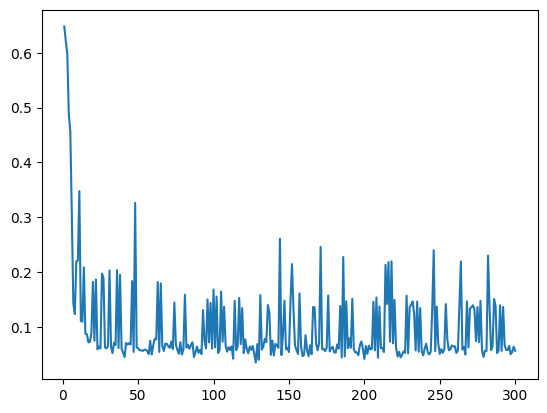

In [198]:
loss_history = [loss.detach() for loss in loss_history]
plt.plot(range(1, len(loss_history)+1), loss_history)

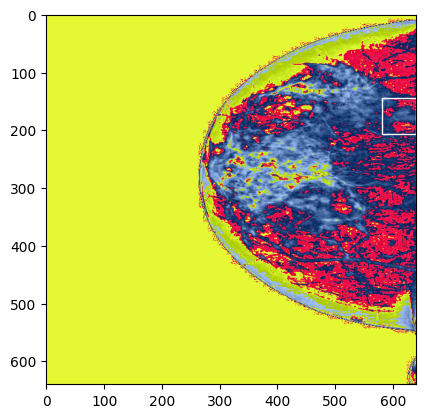

In [199]:

image, label = train_dataset.__getitem__(0)
x,y,xf,yf = label['boxes'][0] * 640

fig, ax = plt.subplots()
image = F.to_pil_image(image)
plt.imshow(image)
rect = patches.Rectangle((x, y), xf-x, yf-y, linewidth=1, edgecolor='white', facecolor='none')
ax.add_patch(rect)


tensor(222.8892) tensor(248.8113)


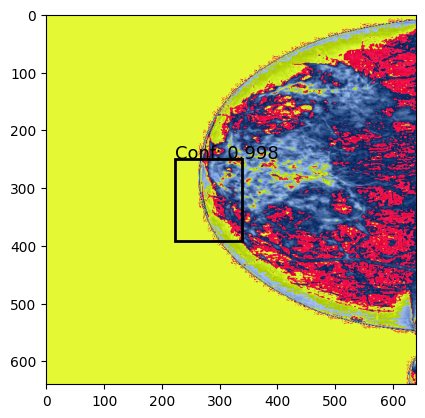

In [214]:
image, label = train_dataset.__getitem__(0)
images = image.reshape((1,3,640,640))

outputs = model(images)

prob_pred = outputs['pred_logits'][0].detach()
box_pred = outputs['pred_boxes'][0].detach()

fig, ax = plt.subplots()
image = F.to_pil_image(image)
plt.imshow(image)


threshold = 0.5

for i in range(QUERIES):
    prob = prob_pred[i]
    box = box_pred[i]

    if prob < threshold:
        continue

    x,y,xf,yf = box * 640
    print(x,y)
    rect = patches.Rectangle((x, y), xf-x, yf-y, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    ax.annotate(f'[P: {np.round(prob.item(),3)}]', xy=(x,y), fontsize=13)

